In [1]:
!pip install geopandas folium contextily cartopy descartes -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 21.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Circle, FancyArrowPatch
from matplotlib.path import Path
import matplotlib.patches as patches
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set high DPI for publication quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 0.5

In [4]:
#drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('YOUR PATH/ai_value_chain.txt')
print("Data loaded from .txt file")

Data loaded from .txt file


In [6]:
# Create geometry column for mapping
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# Filter out global entries and environmental impact for mapping
gdf_map = gdf[gdf['country'] != 'Global'].copy()
gdf_map = gdf_map[gdf_map['category'] != 'environmental_impact'].copy()

In [7]:
print(f"Total sites: {len(gdf_map)}")
print(f"Categories: {sorted(gdf_map['category'].unique())}")
print(f"Regions covered: {sorted(gdf_map['region'].unique())}")

Total sites: 47
Categories: ['ai_research', 'data_centers', 'digital_labor', 'environmental_impact', 'mineral_extraction']
Regions covered: ['Africa', 'Asia', 'Central Africa', 'Europe', 'Middle East', 'North America', 'Oceania', 'South America']


In [8]:
#Define Global South
global_south_countries = [
    'Democratic Republic of Congo', 'Bolivia', 'Chile', 'Myanmar', 'Indonesia',
    'India', 'Philippines', 'Kenya', 'Venezuela', 'Brazil', 'South Africa',
    'Argentina', 'Peru', 'Madagascar', 'Papua New Guinea', 'Guinea'
]

gdf_map['region_type'] = gdf_map['country'].apply(
    lambda x: 'Global South' if x in global_south_countries else 'Global North'
)

print(f"\nGlobal South sites: {sum(gdf_map['region_type'] == 'Global South')}")
print(f"Global North sites: {sum(gdf_map['region_type'] == 'Global North')}")


Global South sites: 29
Global North sites: 18


In [9]:
print("\nCategory distribution:")
print(gdf_map['category'].value_counts())


Category distribution:
category
mineral_extraction      25
data_centers             7
digital_labor            6
ai_research              6
environmental_impact     3
Name: count, dtype: int64


In [11]:
gdf.head(50)

,site_id,site_name,country,region,category,subcategory,latitude,longitude,production_volume,production_unit,workforce_size,avg_wage_usd_monthly,environmental_impact_score,human_rights_violations,key_companies,source_authors,data_year,geometry
0,1,Tenke Fungurume Mine,Democratic Republic of Congo,Central Africa,mineral_extraction,cobalt,-10.7000,26.1000,2.850000e+04,MT_annual,15000.0,60.0,9,child_labor,China Molybdenum,"Crawford, RAID",2023,POINT (26.1 -10.7)
1,2,Kolwezi Mining District,Democratic Republic of Congo,Central Africa,mineral_extraction,cobalt,-10.7000,25.5000,8.400000e+04,MT_annual_district,40000.0,50.0,10,child_labor_water_contamination,"Glencore, Eurasian Resources","Crawford, Kara",2024,POINT (25.5 -10.7)
2,3,Mutanda Mine,Democratic Republic of Congo,Central Africa,mineral_extraction,cobalt,-10.8000,25.6000,2.730000e+04,MT_annual,8000.0,65.0,8,environmental_degradation,Glencore,"Crawford, RAID",2018,POINT (25.6 -10.8)
3,4,KOV Mine,Democratic Republic of Congo,Central Africa,mineral_extraction,cobalt,-10.7300,25.4700,1.500000e+04,MT_annual,5000.0,55.0,8,labor_violations,"COMIDE, Gécamines","Amnesty, Crawford",2023,POINT (25.47 -10.73)
4,5,Salar de Uyuni,Bolivia,South America,mineral_extraction,lithium,-20.1300,-67.4900,2.300000e+07,MT_reserves,2000.0,800.0,7,indigenous_displacement,"YLB, Lilac Solutions","Harvard IRR, Human Rights Pulse",2024,POINT (-67.49 -20.13)
5,6,Salar de Atacama,Chile,South America,mineral_extraction,lithium,-24.0000,-69.0000,1.800000e+05,MT_annual,3500.0,1200.0,8,water_depletion,"SQM, Albemarle",Harvard IRR,2023,POINT (-69 -24)
6,7,Bayan Obo Mine,China,Asia,mineral_extraction,rare_earth,41.8000,109.9000,4.500000e+04,MT_annual,25000.0,400.0,10,radioactive_contamination,China Northern Rare Earth,"Harvard IRR, IPS",2024,POINT (109.9 41.8)
7,8,Myanmar Kachin State,Myanmar,Asia,mineral_extraction,rare_earth,25.0000,98.0000,3.100000e+04,MT_annual,50000.0,150.0,10,toxic_exposure_death,Military Junta,Global Witness,2024,POINT (98 25)
8,9,Escondida Mine,Chile,South America,mineral_extraction,copper,-24.3000,-69.1000,1.350000e+06,MT_annual,8000.0,2500.0,6,water_usage,BHP Billiton,NS Energy,2023,POINT (-69.1 -24.3)
9,10,Bangka Island,Indonesia,Asia,mineral_extraction,tin,-2.0000,106.0000,8.000000e+04,MT_annual,150000.0,300.0,9,marine_ecosystem_destruction,"PT Timah, illegal miners",Geographical,2023,POINT (106 -2)


In [12]:
# Define color palette for categories
color_scheme = {
    'mineral_extraction': '#d32f2f',    # Deep red - extraction/exploitation
    'digital_labor': '#1976d2',        # Blue - labor/workers
    'ai_research': '#388e3c',          # Green - research/development
    'data_centers': '#f57c00',         # Orange - infrastructure
    #'environmental_impact': '#388e3c'   # Green - environmental
}

# Define custom display names for legend (overrides automatic title formatting)
category_display_names = {
    'mineral_extraction': 'Mineral Extraction',
    'digital_labor': 'Digital Labor',
    'ai_research': 'AI Research and Development',
    'data_centers': 'Data Centers',
    #'environmental_impact': 'Environmental Impact'
}

In [13]:
# Marker sizes based on impact/significance
def get_marker_size(row):
    """Calculate marker size based on category and data"""
    base_size = 40

    if row['category'] == 'mineral_extraction':
        # Size based on environmental impact score and production volume
        environmental_score = pd.to_numeric(row.get('environmental_impact_score', pd.NA), errors='coerce')

        # Additional scaling for high-impact materials like nickel, lithium, rare earth
        impact_materials = ['nickel', 'lithium', 'rare_earth', 'cobalt']
        material_bonus = 15 if row.get('subcategory') in impact_materials else 0

        if pd.notna(environmental_score):
            return base_size + (environmental_score * 8) + material_bonus
        return base_size + 20 + material_bonus

    elif row['category'] == 'digital_labor':
        # Size based on workforce
        if 'workforce_size' in row and pd.notna(row['workforce_size']):
            return base_size + min(row['workforce_size'] / 10000, 40)
        return base_size + 15

    elif row['category'] == 'ai_research':
        # Size based on wages (proxy for concentration of value)
        if 'avg_wage_usd_monthly' in row and pd.notna(row['avg_wage_usd_monthly']):
            return base_size + min(row['avg_wage_usd_monthly'] / 5000, 35)
        return base_size + 25

    elif row['category'] == 'data_centers':
        # Size based on capacity or environmental impact
        return base_size + 20

    else:
        return base_size

# Apply marker sizes
gdf_map['marker_size'] = gdf_map.apply(get_marker_size, axis=1)

In [14]:
def create_curved_arrow(ax, start_lon, start_lat, end_lon, end_lat, color, alpha=0.6, linewidth=2):
    """Create a curved arrow between two geographic points"""

    # Transform start and end coordinates to map projection
    start_proj = ccrs.Robinson().transform_point(start_lon, start_lat, ccrs.PlateCarree())
    end_proj = ccrs.Robinson().transform_point(end_lon, end_lat, ccrs.PlateCarree())

    # Calculate midpoint and curve control point
    mid_x = (start_proj[0] + end_proj[0]) / 2
    mid_y = (start_proj[1] + end_proj[1]) / 2

    # Create curve by offsetting midpoint
    # Offset perpendicular to the line for a nice curve
    dx = end_proj[0] - start_proj[0]
    dy = end_proj[1] - start_proj[1]

    # Calculate perpendicular offset (curve height)
    curve_height = np.sqrt(dx**2 + dy**2) * 0.2  # 20% of distance
    perp_x = -dy / np.sqrt(dx**2 + dy**2) * curve_height
    perp_y = dx / np.sqrt(dx**2 + dy**2) * curve_height

    control_x = mid_x + perp_x
    control_y = mid_y + perp_y

    # Create curved path using Bezier curve
    curve = patches.FancyArrowPatch(
        start_proj, end_proj,
        connectionstyle=f"arc3,rad=0.3",
        arrowstyle='->',
        mutation_scale=20,
        alpha=alpha,
        color=color,
        linewidth=linewidth,
        linestyle='-',
        transform=ccrs.Robinson()._as_mpl_transform(ax)
    )

    ax.add_patch(curve)

    return curve

In [15]:
def hiddenAI_map_with_flows():
    """Static map with flow arrows showing Global South → Global North relationships"""

    # Create figure with specific size for 300 DPI
    fig = plt.figure(figsize=(20, 14))  # Larger to accommodate more flows

    # Use Robinson projection for global view
    ax = plt.axes(projection=ccrs.Robinson())

    # Set global extent
    ax.set_global()

    # Add map features with academic styling
    ax.add_feature(cfeature.LAND, facecolor='#f5f5f5', edgecolor='none')
    ax.add_feature(cfeature.OCEAN, facecolor='#e3f2fd', edgecolor='none')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='#757575')
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, color='#9e9e9e', alpha=0.7)

    # Add graticules (lat/lon grid) for academic maps
    gl = ax.gridlines(draw_labels=False, linewidth=0.3, color='#bdbdbd', alpha=0.5)

    # ENHANCED FLOW ARROWS: Including new mining sites
    rare_earth_hub_flows = [
        # Bayan Obo (China) → Multiple destinations (China's dominant rare earth source)
        {'start': (109.9, 41.8), 'end': (116.4, 39.9), 'label': 'Rare Earth Hub', 'weight': 5},    # → Beijing
        {'start': (109.9, 41.8), 'end': (-122.1, 37.4), 'label': 'Rare Earth Hub', 'weight': 5},  # → Silicon Valley
        {'start': (109.9, 41.8), 'end': (-0.1, 51.5), 'label': 'Rare Earth Hub', 'weight': 5},    # → London
        {'start': (109.9, 41.8), 'end': (8.7, 50.1), 'label': 'Rare Earth Hub', 'weight': 4},     # → Frankfurt
        {'start': (109.9, 41.8), 'end': (121.5, 31.2), 'label': 'Rare Earth Hub', 'weight': 4},   # → Shanghai
        # Myanmar Rare Earth → Beijing (established flow)
        {'start': (98.0, 25.0), 'end': (116.4, 39.9), 'label': 'Rare Earth', 'weight': 3}
    ]
    # Primary mineral extraction flows (RED arrows) - Major established flows
    primary_mineral_flows = [
        # DRC Cobalt → Silicon Valley (established flow)
        {'start': (25.5, -10.7), 'end': (-122.1, 37.4), 'label': 'Cobalt', 'weight': 3},
        # Lithium Triangle → Silicon Valley (established flow)
        {'start': (-67.49, -20.13), 'end': (-122.1, 37.4), 'label': 'Lithium', 'weight': 3},
        # Chilean Copper → Boston (established flow)
        {'start': (-69.1, -24.3), 'end': (-71.1, 42.4), 'label': 'Copper', 'weight': 2},
    ]

    # Secondary mineral extraction flows (RED arrows) - New important flows
    secondary_mineral_flows = [
        # Indonesian Nickel → Beijing (for EV batteries)
        {'start': (121.3742, -2.5736), 'end': (116.4, 39.9), 'label': 'Nickel', 'weight': 2},
        # Philippines Nickel → Silicon Valley
        {'start': (117.4189, 8.57), 'end': (-122.1, 37.4), 'label': 'Nickel', 'weight': 2},
        # Russian Nickel → London (European supply)
        {'start': (88.2167, 69.3333), 'end': (-0.1, 51.5), 'label': 'Nickel', 'weight': 2},
        # Australian Lithium → Silicon Valley
        {'start': (116.0647, -33.8661), 'end': (-122.1, 37.4), 'label': 'Lithium', 'weight': 2},
        # Argentina Lithium → Boston
        {'start': (-67.0833, -25.5), 'end': (-71.1, 42.4), 'label': 'Lithium', 'weight': 1},
        # Guinea Bauxite → London (aluminum for tech)
        {'start': (-14.05, 10.15), 'end': (-0.1, 51.5), 'label': 'Bauxite', 'weight': 1},
        # PNG Copper → Silicon Valley
        {'start': (141.03, -5.03), 'end': (-122.1, 37.4), 'label': 'Copper', 'weight': 1},
    ]

    # Digital labor flows (BLUE arrows) - Established flows
    digital_flows = [
        # Bangalore → Silicon Valley
        {'start': (77.6, 12.97), 'end': (-122.1, 37.4), 'label': 'Data Annotation', 'weight': 2},
        # Manila → Silicon Valley
        {'start': (121.0, 14.6), 'end': (-122.1, 37.4), 'label': 'Content Moderation', 'weight': 2},
        # Nairobi → London
        {'start': (36.82, -1.29), 'end': (-0.1, 51.5), 'label': 'Content Moderation', 'weight': 2},
        # São Paulo → Toronto
        {'start': (-46.6, -23.5), 'end': (-79.4, 43.7), 'label': 'BPO Services', 'weight': 1},
        # Cape Town → London
        {'start': (18.4, -33.9), 'end': (-0.1, 51.5), 'label': 'BPO Services', 'weight': 1},
        # Caracas → Silicon Valley
        {'start': (-66.9, 10.5), 'end': (-122.1, 37.4), 'label': 'Platform Work', 'weight': 1},
    ]

    # Draw primary mineral extraction arrows (thicker)
    print("Drawing primary mineral flows...")
    for flow in primary_mineral_flows:
        create_curved_arrow(
            ax, flow['start'][0], flow['start'][1],
            flow['end'][0], flow['end'][1],
            color=color_scheme['mineral_extraction'],
            alpha=0.8, linewidth=flow['weight']
        )

    # Draw secondary mineral extraction arrows (thinner)
    print("Drawing secondary mineral flows...")
    for flow in secondary_mineral_flows:
        create_curved_arrow(
            ax, flow['start'][0], flow['start'][1],
            flow['end'][0], flow['end'][1],
            color=color_scheme['mineral_extraction'],
            alpha=0.6, linewidth=flow['weight']
        )

    # Draw digital labor arrows
    print("Drawing digital labor flows...")
    for flow in digital_flows:
        create_curved_arrow(
            ax, flow['start'][0], flow['start'][1],
            flow['end'][0], flow['end'][1],
            color=color_scheme['digital_labor'],
            alpha=0.7, linewidth=flow['weight']
        )

    # Plot all points by category
    print("Plotting all data points...")
    for category in gdf_map['category'].unique():
        category_data = gdf_map[gdf_map['category'] == category]

        if len(category_data) > 0:
            # Transform coordinates to map projection
            x_coords = []
            y_coords = []
            sizes = []

            for idx, row in category_data.iterrows():
                # Transform coordinates
                proj_coords = ccrs.Robinson().transform_point(
                    row['longitude'], row['latitude'], ccrs.PlateCarree()
                )
                x_coords.append(proj_coords[0])
                y_coords.append(proj_coords[1])
                sizes.append(row['marker_size'])

            # Plot with category-specific styling
            ax.scatter(
                x_coords, y_coords,
                s=sizes,
                c=color_scheme[category],
                alpha=0.9,  # Higher alpha for points over arrows
                edgecolors='white',
                linewidths=2,
                label=category.replace('_', ' ').title(),
                transform=ccrs.Robinson(),
                zorder=10  # High z-order to appear above arrows
            )

    # Create legend with arrows
    legend_elements = []
    for category, color in color_scheme.items():
        # Use custom display name if available, otherwise fall back to automatic formatting
        display_name = category_display_names.get(category, category.replace('_', ' ').title())
        legend_elements.append(
            plt.scatter([], [], s=100, c=color, alpha=0.8, edgecolors='white', linewidths=1.5,
                       label=display_name)
        )

    # Add arrow legend entries
    legend_elements.append(
        plt.Line2D([0], [0], color=color_scheme['mineral_extraction'], linewidth=4, alpha=0.8,
                  label='Resource Flow')
    )
    #legend_elements.append(
    #    plt.Line2D([0], [0], color=color_scheme['mineral_extraction'], linewidth=2, alpha=0.6,
    #              label='Secondary Resource Flow')
    #)
    legend_elements.append(
        plt.Line2D([0], [0], color=color_scheme['digital_labor'], linewidth=3, alpha=0.7,
                  label='Digital Labor Flow')
    )

    # Position legend
    legend = ax.legend(
        handles=legend_elements,
        loc='lower left',
        bbox_to_anchor=(0.02, 0.02),
        frameon=True,
        fancybox=False,
        shadow=False,
        framealpha=0.95,
        edgecolor='#666666',
        fontsize=10
    )
    legend.get_frame().set_facecolor('white')

    # Remove axes for clean look
    ax.set_frame_on(False)

    # Adjust layout to accommodate titles
    plt.subplots_adjust(top=0.88)

    return fig, ax

In [18]:
def add_flow_annotations():
    """Add text annotations for key flows including new mining regions"""

    # Flow labels including new regions
    flow_labels = [

        #{'text': 'Nd, Dy, Y', 'lat': 35, 'lon': 60, 'color': color_scheme['mineral_extraction']},
        {'text': 'Rare Earth Materials\n→ Data & AI Hardware', 'lat': 35, 'lon': 95, 'color': color_scheme['mineral_extraction']},
        #{'text': 'Li, Co, Ni', 'lat': -20, 'lon': -45, 'color': color_scheme['mineral_extraction']},
        #{'text': 'Li', 'lat': -35, 'lon': -55, 'color': color_scheme['mineral_extraction']},
        {'text': 'Mineral Extraction\n→ Data & AI Hardware', 'lat': -8, 'lon': -70, 'color': color_scheme['mineral_extraction']},
        #{'text': 'Ni', 'lat': 5, 'lon': 115, 'color': color_scheme['mineral_extraction']},
        #{'text': 'Al, Rare Metals', 'lat': 15, 'lon': -5, 'color': color_scheme['mineral_extraction']},
        {'text': 'Digital Labor\n→ AI Training', 'lat': 18, 'lon': 58, 'color': color_scheme['digital_labor']},
        #{'text': 'Digital Labor\n→ AI Training', 'lat': 0, 'lon': 45, 'color': color_scheme['digital_labor']},
        #{'text': 'Platform Labor', 'lat': 5, 'lon': -25, 'color': color_scheme['digital_labor']},
        #{'text': 'AI Innovation Hub', 'lat': 30, 'lon': -130, 'color': color_scheme['ai_research']},
        #{'text': 'Asian AI Center', 'lat': 50, 'lon': 125, 'color': color_scheme['ai_research']},
        #{'text': 'European AI Center', 'lat': 60, 'lon': 5, 'color': color_scheme['ai_research']},
        #{'text': 'AI Research', 'lat': 55, 'lon': -110, 'color': color_scheme['ai_research']},
        {'text': 'Value Concentration\n→ AI Innovation & Research', 'lat': 55, 'lon': -55, 'color': color_scheme['ai_research']}
    ]

    for label in flow_labels:
        # Transform coordinates
        proj_coords = ccrs.Robinson().transform_point(
            label['lon'], label['lat'], ccrs.PlateCarree()
        )

        # Add annotation
        ax.text(
            proj_coords[0], proj_coords[1],
            label['text'],
            fontsize=10,
            fontweight='bold',
            color=label['color'],
            ha='center',
            va='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor=label['color']),
            transform=ccrs.Robinson()
        )


Drawing primary mineral flows...
Drawing secondary mineral flows...
Drawing digital labor flows...
Plotting all data points...


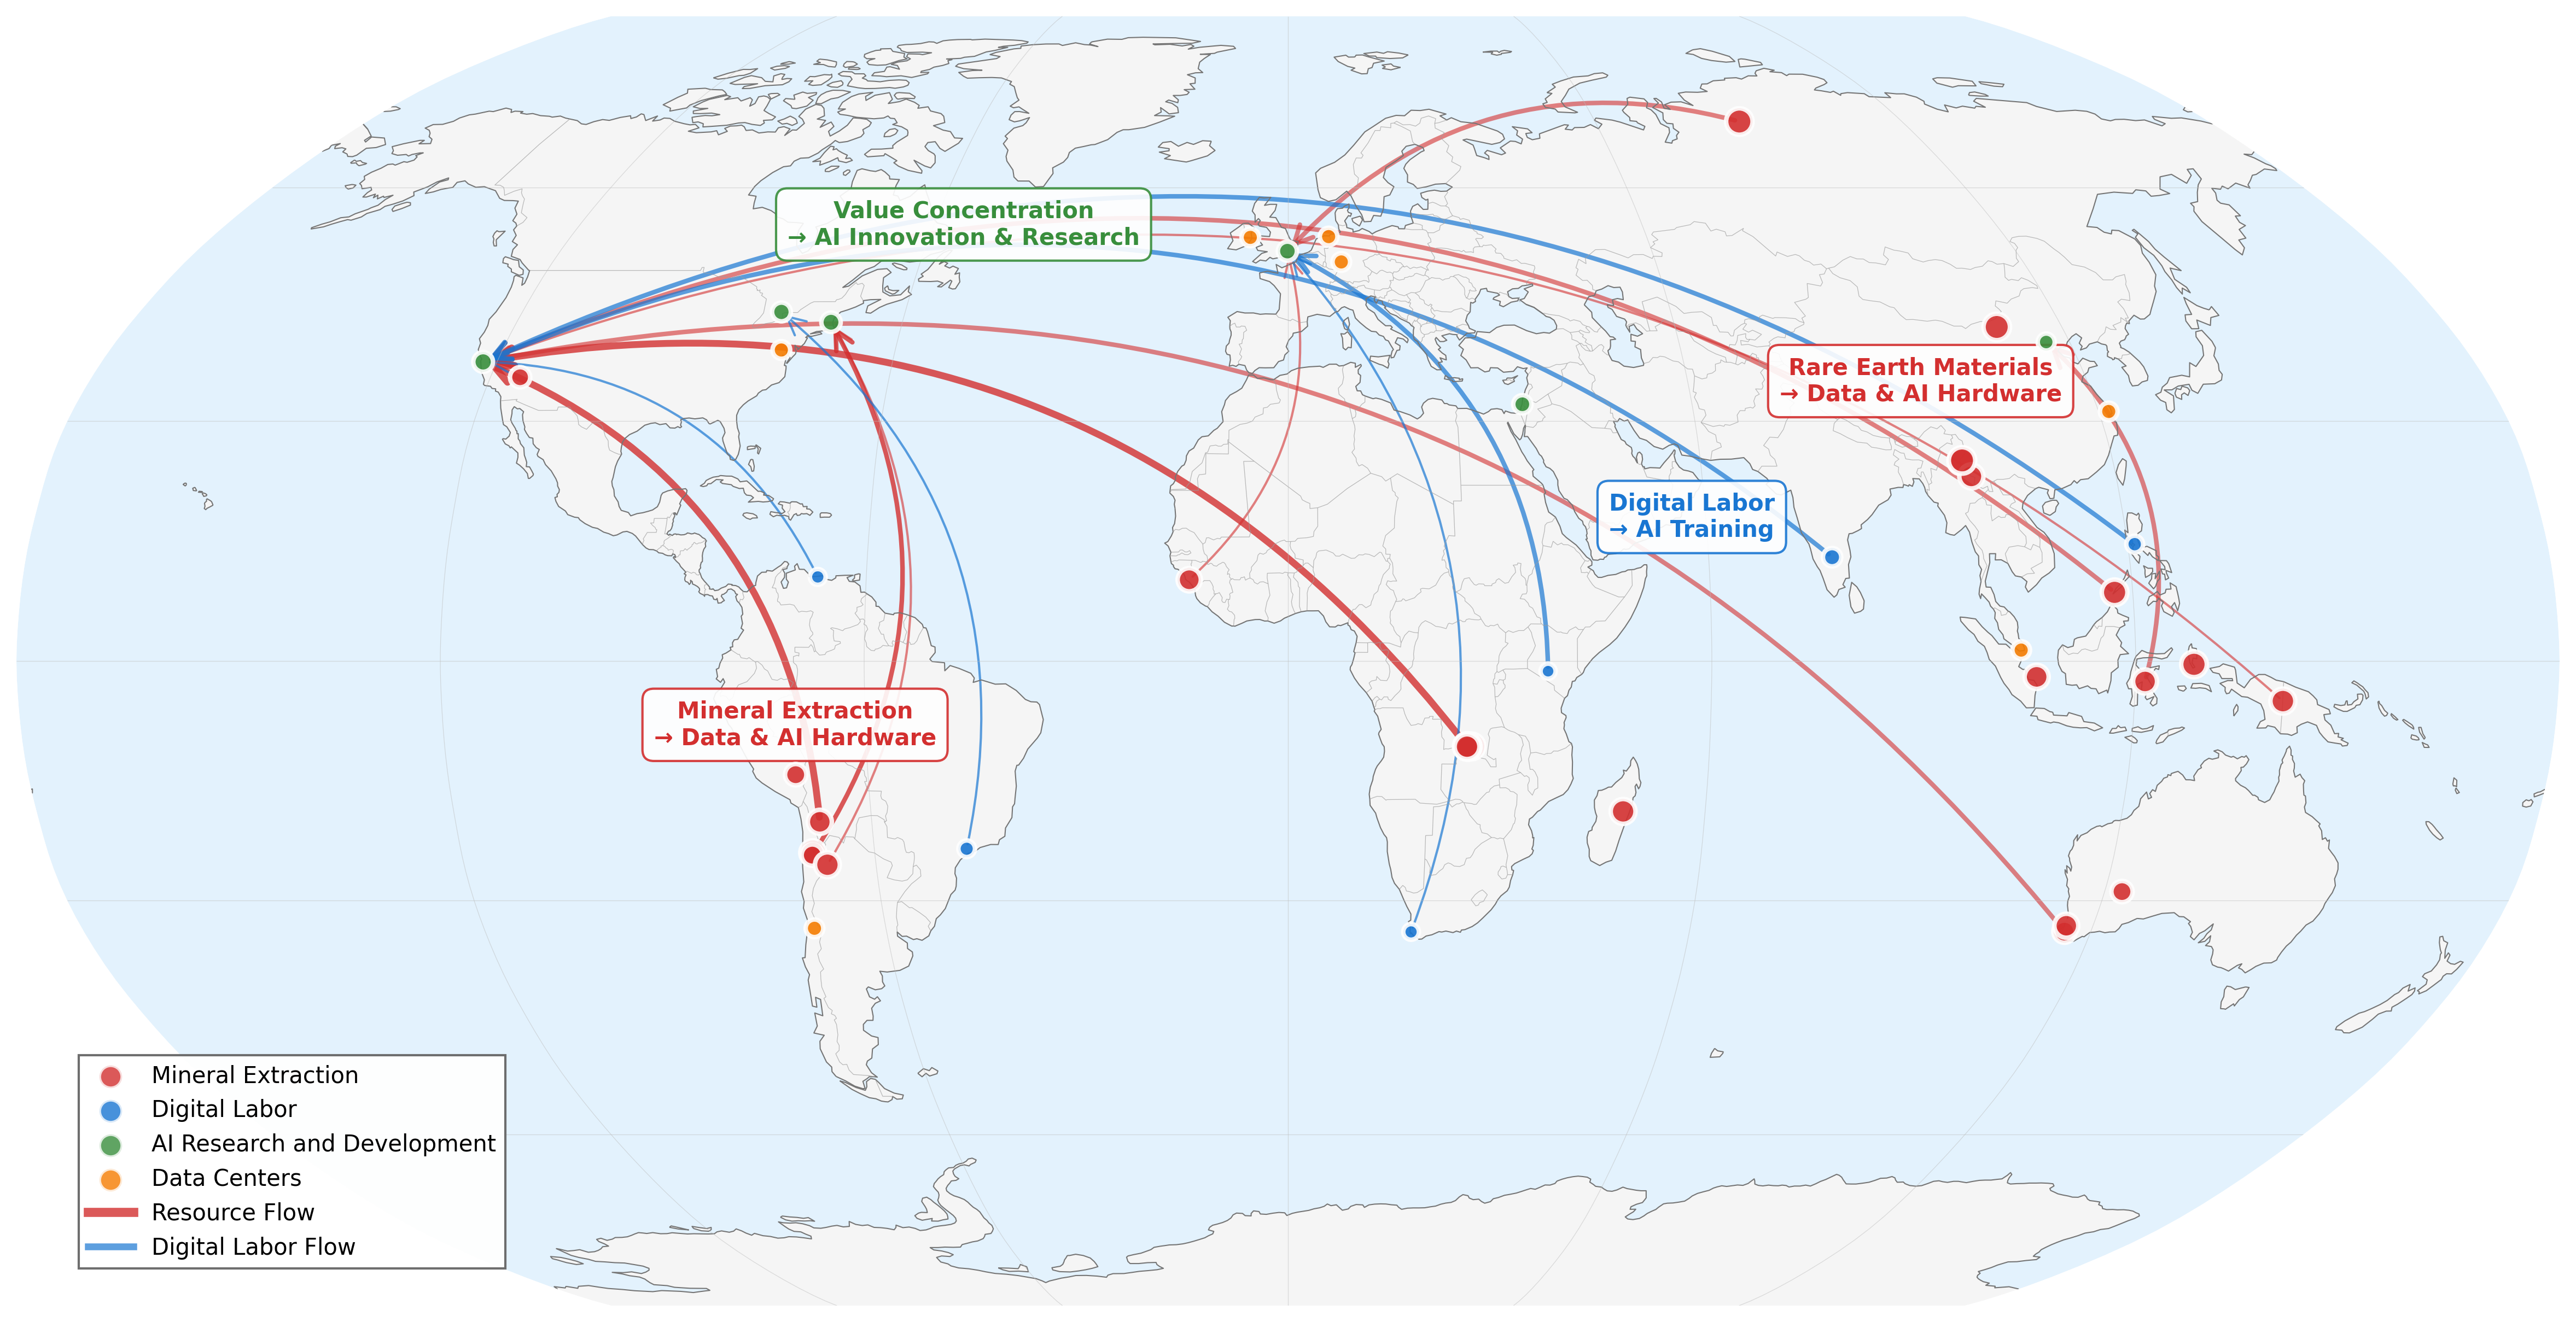

In [19]:
fig, ax = hiddenAI_map_with_flows()

# Add flow annotations
add_flow_annotations()

# Save and display the map
plt.savefig('/content/drive/MyDrive/Diversa/Alan Turing/hidden_ai_map.png', dpi=300, bbox_inches='tight')
plt.savefig('/content/drive/MyDrive/Diversa/Alan Turing/hidden_ai_map.png', dpi=300, bbox_inches='tight')
plt.show()